# Data exploration

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import tensorflow as tf
import pathlib
import PIL
import pydot

In [3]:
tf.__version__

'2.3.0'

## - Loading dataset using tensorflow - PIL.Image

In [4]:
path = "C:\\Users\\Ashika\\Desktop\\My Notebooks\\INT248 project files\\Dataset"
path = pathlib.Path(path)
#normal = list(path.glob('normal_xray/*'))
#print(len(normal))
#PIL.Image.open(str(normal[0]))'''

## - Loading dataset using keras.preprocessing.image_dataset_drom_directory

In [5]:
batch_size = 32
height = 100
width = 150

In [9]:
train_path = pathlib.Path('C:\\Users\\Ashika\\Desktop\\My Notebooks\\INT248 project files\\Dataset\\train')
test_path = pathlib.Path('C:\\Users\\Ashika\\Desktop\\My Notebooks\\INT248 project files\\Dataset\\test')
valid_path = pathlib.Path('C:\\Users\\Ashika\\Desktop\\My Notebooks\\INT248 project files\\Dataset\\valid')
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    shuffle=True,
    seed=123,
    image_size=(height,width),
    batch_size=batch_size
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=True,
    seed=123,
    image_size=(height,width),
    batch_size=batch_size
)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    valid_path,
    shuffle=True,
    seed=123,
    image_size=(height,width),
    batch_size=batch_size
)
class_names = train_dataset.class_names
print(class_names)

Found 613 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
['adenocarcinoma', 'large.cell.carcinoma', 'normal_xray', 'squamous.cell.carcinoma']


## - Visualizing some images from dataset along with labels

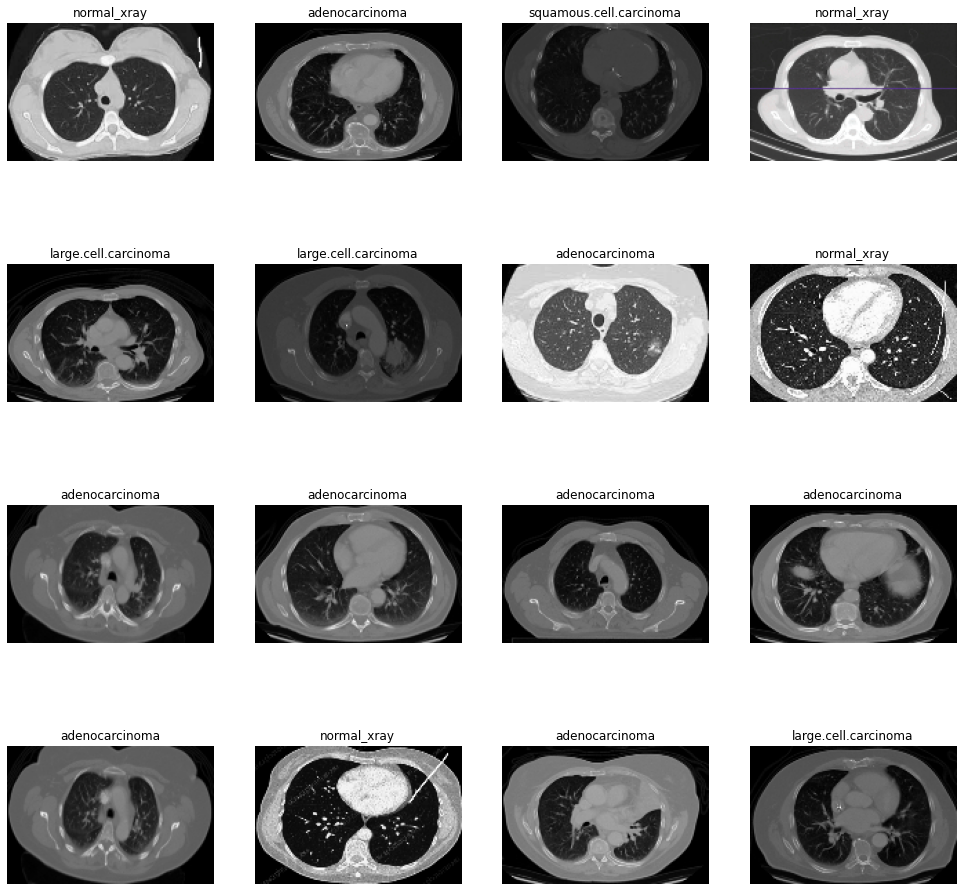

In [10]:
plt.figure(figsize=(17,17))
for img, label in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

# Data Wrangling

In [11]:
print(train_dataset)
for img, label in train_dataset:
    print("Image shape: {}\tLabel shape: {}".format(img.shape,label.shape))
    break

<BatchDataset shapes: ((None, 100, 150, 3), (None,)), types: (tf.float32, tf.int32)>
Image shape: (32, 100, 150, 3)	Label shape: (32,)


In [12]:
normalise_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_dataset = train_dataset.map(lambda x, y: (normalise_layer(x), y))
img_batch, label_batch = next(iter(normalized_dataset))
first_img = img_batch[0]
print(np.min(first_img),np.max(first_img))

0.0 0.9666667


In [14]:
autotune = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=autotune)
test_dataset = test_dataset.cache().prefetch(buffer_size=autotune)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=autotune)
print(train_dataset)

<PrefetchDataset shapes: ((None, 100, 150, 3), (None,)), types: (tf.float32, tf.int32)>


# Building our Model

## - Basic model

In [15]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

### Activation function comparision:
- Sigmoid : Loss = 1.38, Accuracy = 0.28
- Tanh    : Loss = 0.39, Accuracy = 0.85
- Softmax : Loss = 1.37, Accuracy = 0.28
- ReLu    : Loss = 0.41, Accuracy = 0.82
#### The one with least loss and highest accuracy is to be selected. Thus, am moving forward with tanh.

## - Upgrading our model..

In [56]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as ker
class CancerModel():
    @staticmethod
    def cancer(height,width,depth,classes):
        model=Sequential()
        shape=(height,width,depth)
        channelDim=-1
        if ker.image_data_format()=="channels_first":
          shape=(depth,height,width)
          channelDim=1
        model.add(SeparableConv2D(32, (3,3), padding="same",input_shape=shape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        model.add(SeparableConv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDim))
        model.add(SeparableConv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        model.add(SeparableConv2D(128, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDim))
        model.add(SeparableConv2D(128, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDim))
        model.add(SeparableConv2D(128, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

In [40]:
epochs=50
init_lr = 1e-2
batch_size = 32

In [48]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adagrad
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
trainAug = ImageDataGenerator(
  rescale=1/255.0,
  rotation_range=20,
  zoom_range=0.05,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.05,
  horizontal_flip=True,
  vertical_flip=True,
  fill_mode="nearest")
valAug=ImageDataGenerator(rescale=1 / 255.0)
trainGen = trainAug.flow_from_directory(
  train_path,
  class_mode="categorical",
  target_size=(48,48),
  color_mode="rgb",
  shuffle=True,
  batch_size=32)
valGen = valAug.flow_from_directory(
  valid_path,
  class_mode="categorical",
  target_size=(48,48),
  color_mode="rgb",
  shuffle=False,
  batch_size=32)
testGen = valAug.flow_from_directory(
  test_path,
  class_mode="categorical",
  target_size=(48,48),
  color_mode="rgb",
  shuffle=False,
  batch_size=32)
from imutils import paths
lenTrain=len(list(paths.list_images(train_path)))
lenVal=len(list(paths.list_images(valid_path)))
lenTest=len(list(paths.list_images(test_path)))
mymodel = CancerModel.cancer(width=48,height=48,depth=3,classes=4)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


# Moving on to the last step...

## - Comparing the optimizers' performance, one by one

In [49]:
performance = []

Epoch 1/50
19/19 [==============================] - 18s 968ms/step - loss: 0.3784 - accuracy: 0.6558 - val_loss: 1.2373 - val_accuracy: 0.2344
Epoch 2/50
19/19 [==============================] - 18s 942ms/step - loss: 0.3747 - accuracy: 0.6231 - val_loss: 1.1542 - val_accuracy: 0.2188
Epoch 3/50
19/19 [==============================] - 18s 930ms/step - loss: 0.3815 - accuracy: 0.6437 - val_loss: 0.7062 - val_accuracy: 0.1250
Epoch 4/50
19/19 [==============================] - 18s 926ms/step - loss: 0.3608 - accuracy: 0.6575 - val_loss: 0.6932 - val_accuracy: 0.3125
Epoch 5/50
19/19 [==============================] - 18s 934ms/step - loss: 0.3783 - accuracy: 0.6179 - val_loss: 0.6217 - val_accuracy: 0.3125
Epoch 6/50
19/19 [==============================] - 18s 955ms/step - loss: 0.3673 - accuracy: 0.6506 - val_loss: 0.6824 - val_accuracy: 0.3750
Epoch 7/50
19/19 [==============================] - 18s 965ms/step - loss: 0.3608 - accuracy: 0.6678 - val_loss: 0.5630 - val_accuracy: 0.4531

C:\Users\Ashika\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

         adenocarcinoma       0.42      0.42      0.42       120
   large.cell.carcinoma       0.35      0.43      0.39        51
            normal_xray       0.40      1.00      0.57        54
squamous.cell.carcinoma       0.00      0.00      0.00        90

               accuracy                           0.40       315
              macro avg       0.29      0.46      0.35       315
           weighted avg       0.29      0.40      0.32       315

------------------------------------------------------------------
Classification matrix: 
[[50 24 46  0]
 [14 22 15  0]
 [ 0  0 54  0]
 [55 16 19  0]]

Accuracy: 0.2286
Specificity: 0.6111
Sensitivity: 0.6757
------------------------------------------------------------------
------------------------------------------------------------------


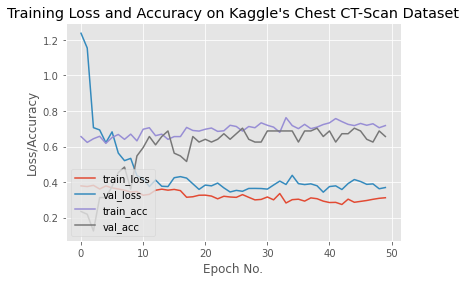

In [52]:
#Adagrad optimizer
opt=Adagrad(lr=init_lr,decay=init_lr/epochs)
mymodel.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
M_adagrad=mymodel.fit_generator(
  trainGen,
  steps_per_epoch=lenTrain//batch_size,
  validation_data=valGen,
  validation_steps=lenVal//batch_size,
  epochs=epochs)
print("Evaluating the model with Adagrad optimizer.....\n")
print('------------------------------------------------------------------')
testGen.reset()
pred_indices=mymodel.predict_generator(testGen,steps=(lenTest//batch_size)+1)
pred_indices=np.argmax(pred_indices,axis=1)
print(classification_report(testGen.classes, pred_indices, target_names=testGen.class_indices.keys()))
print('------------------------------------------------------------------')
cm=confusion_matrix(testGen.classes,pred_indices)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
specificity=cm[1,1]/(cm[1,0]+cm[1,1])
sensitivity=cm[0,0]/(cm[0,0]+cm[0,1])
print(f"Classification matrix: \n{cm}")
print(f'\nAccuracy: {round(accuracy,4)}')
print(f'Specificity: {round(specificity,4)}')
print(f'Sensitivity: {round(sensitivity,4)}')
performance.append(["Adagrad",round(accuracy,4)])
print('------------------------------------------------------------------')
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), M_adagrad.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), M_adagrad.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), M_adagrad.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), M_adagrad.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Kaggle's Chest CT-Scan Dataset")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('accuracy_vs_error-using_adagrad-plot.png')
print('------------------------------------------------------------------')

Epoch 1/50
19/19 [==============================] - 20s 1s/step - loss: 0.5592 - accuracy: 0.5439 - val_loss: 5.2075 - val_accuracy: 0.3125
Epoch 2/50
19/19 [==============================] - 18s 957ms/step - loss: 0.4842 - accuracy: 0.5439 - val_loss: 6.1109 - val_accuracy: 0.2031
Epoch 3/50
19/19 [==============================] - 19s 1s/step - loss: 0.4880 - accuracy: 0.5491 - val_loss: 6.0524 - val_accuracy: 0.2031
Epoch 4/50
19/19 [==============================] - 18s 962ms/step - loss: 0.4443 - accuracy: 0.5594 - val_loss: 6.1109 - val_accuracy: 0.2031
Epoch 5/50
19/19 [==============================] - 19s 986ms/step - loss: 0.4433 - accuracy: 0.5422 - val_loss: 6.1109 - val_accuracy: 0.2031
Epoch 6/50
19/19 [==============================] - 18s 966ms/step - loss: 0.4374 - accuracy: 0.5749 - val_loss: 6.1050 - val_accuracy: 0.2031
Epoch 7/50
19/19 [==============================] - 19s 1s/step - loss: 0.4324 - accuracy: 0.5594 - val_loss: 6.0498 - val_accuracy: 0.2031
Epoch 8/

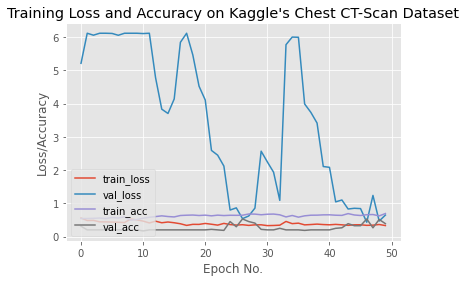

In [53]:
#Adam optimizer
from keras.optimizers import Adam
opt=Adam(learning_rate=init_lr,amsgrad=False,name="Adam")
mymodel.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
M_adam=mymodel.fit_generator(
  trainGen,
  steps_per_epoch=lenTrain//batch_size,
  validation_data=valGen,
  validation_steps=lenVal//batch_size,
  epochs=epochs)
print("Evaluating the model with Adam optimizer.....\n")
print('------------------------------------------------------------------')
testGen.reset()
pred_indices=mymodel.predict_generator(testGen,steps=(lenTest//batch_size)+1)
pred_indices=np.argmax(pred_indices,axis=1)
print(classification_report(testGen.classes, pred_indices, target_names=testGen.class_indices.keys()))
print('------------------------------------------------------------------')
cm=confusion_matrix(testGen.classes,pred_indices)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
specificity=cm[1,1]/(cm[1,0]+cm[1,1])
sensitivity=cm[0,0]/(cm[0,0]+cm[0,1])
print(f"Classification matrix: \n{cm}")
print(f'\nAccuracy: {round(accuracy,4)}')
print(f'Specificity: {round(specificity,4)}')
print(f'Sensitivity: {round(sensitivity,4)}')
performance.append(["Adam",round(accuracy,4)])
print('------------------------------------------------------------------')
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), M_adam.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), M_adam.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), M_adam.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), M_adam.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Kaggle's Chest CT-Scan Dataset")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('accuracy_vs_error-using_adam-plot.png')
print('------------------------------------------------------------------')

Epoch 1/50
19/19 [==============================] - 22s 1s/step - loss: 0.2965 - accuracy: 0.7108 - val_loss: 0.3718 - val_accuracy: 0.5781
Epoch 2/50
19/19 [==============================] - 20s 1s/step - loss: 0.3099 - accuracy: 0.6919 - val_loss: 0.3526 - val_accuracy: 0.6250
Epoch 3/50
19/19 [==============================] - 19s 1s/step - loss: 0.3055 - accuracy: 0.7177 - val_loss: 0.3525 - val_accuracy: 0.6094
Epoch 4/50
19/19 [==============================] - 18s 957ms/step - loss: 0.3057 - accuracy: 0.7126 - val_loss: 0.3503 - val_accuracy: 0.6406
Epoch 5/50
19/19 [==============================] - 22s 1s/step - loss: 0.3038 - accuracy: 0.7105 - val_loss: 0.3532 - val_accuracy: 0.6406
Epoch 6/50
19/19 [==============================] - 20s 1s/step - loss: 0.3053 - accuracy: 0.7091 - val_loss: 0.3515 - val_accuracy: 0.6406
Epoch 7/50
19/19 [==============================] - 20s 1s/step - loss: 0.3088 - accuracy: 0.7022 - val_loss: 0.3522 - val_accuracy: 0.6406
Epoch 8/50
19/19 

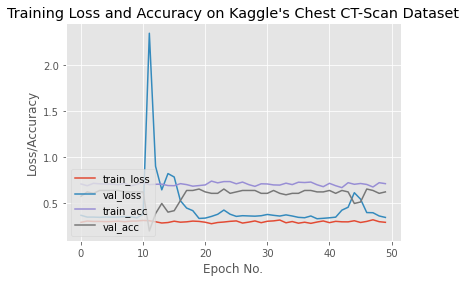

In [59]:
#SGD optimizer
from keras.optimizers import SGD
opt=SGD(learning_rate=init_lr,momentum=0.2,name="SGD")
mymodel.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
M_sgd=mymodel.fit_generator(
  trainGen,
  steps_per_epoch=lenTrain//batch_size,
  validation_data=valGen,
  validation_steps=lenVal//batch_size,
  epochs=epochs)
print("Evaluating the model with SGD optimizer.....\n")
print('------------------------------------------------------------------')
testGen.reset()
pred_indices=mymodel.predict_generator(testGen,steps=(lenTest//batch_size)+1)
pred_indices=np.argmax(pred_indices,axis=1)
print(classification_report(testGen.classes, pred_indices, target_names=testGen.class_indices.keys()))
print('------------------------------------------------------------------')
cm=confusion_matrix(testGen.classes,pred_indices)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
specificity=cm[1,1]/(cm[1,0]+cm[1,1])
sensitivity=cm[0,0]/(cm[0,0]+cm[0,1])
print(f"Classification matrix: \n{cm}")
print(f'\nAccuracy: {round(accuracy,4)}')
print(f'Specificity: {round(specificity,4)}')
print(f'Sensitivity: {round(sensitivity,4)}')
performance.append(["SGD",round(accuracy,4)])
print('------------------------------------------------------------------')
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), M_sgd.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), M_sgd.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), M_sgd.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), M_sgd.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Kaggle's Chest CT-Scan Dataset")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('accuracy_vs_error-using_sgd-plot.png')
print('------------------------------------------------------------------')

Epoch 1/50
19/19 [==============================] - 20s 1s/step - loss: 0.4212 - accuracy: 0.5783 - val_loss: 0.8623 - val_accuracy: 0.3438
Epoch 2/50
19/19 [==============================] - 20s 1s/step - loss: 0.3879 - accuracy: 0.6059 - val_loss: 1.0208 - val_accuracy: 0.3125
Epoch 3/50
19/19 [==============================] - 18s 969ms/step - loss: 0.4129 - accuracy: 0.5921 - val_loss: 0.7526 - val_accuracy: 0.5312
Epoch 4/50
19/19 [==============================] - 19s 990ms/step - loss: 0.3684 - accuracy: 0.6299 - val_loss: 0.7170 - val_accuracy: 0.4375
Epoch 5/50
19/19 [==============================] - 19s 988ms/step - loss: 0.3896 - accuracy: 0.6024 - val_loss: 1.3323 - val_accuracy: 0.2500
Epoch 6/50
19/19 [==============================] - 20s 1s/step - loss: 0.3614 - accuracy: 0.6282 - val_loss: 1.0966 - val_accuracy: 0.3438
Epoch 7/50
19/19 [==============================] - 20s 1s/step - loss: 0.3785 - accuracy: 0.6437 - val_loss: 1.1620 - val_accuracy: 0.3281
Epoch 8/50


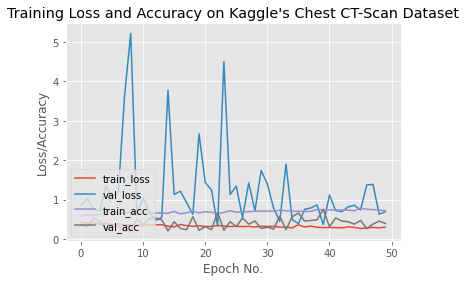

In [60]:
#RMSProp optimizer
from keras.optimizers import RMSprop
opt=RMSprop(learning_rate=init_lr,momentum=0.0,epsilon=1e-07,name="RMSprop")
mymodel.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
M_rmsprop=mymodel.fit_generator(
  trainGen,
  steps_per_epoch=lenTrain//batch_size,
  validation_data=valGen,
  validation_steps=lenVal//batch_size,
  epochs=epochs)
print("Evaluating the model with RMSProp optimizer.....\n")
print('------------------------------------------------------------------')
testGen.reset()
pred_indices=mymodel.predict_generator(testGen,steps=(lenTest//batch_size)+1)
pred_indices=np.argmax(pred_indices,axis=1)
print(classification_report(testGen.classes, pred_indices, target_names=testGen.class_indices.keys()))
print('------------------------------------------------------------------')
cm=confusion_matrix(testGen.classes,pred_indices)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
specificity=cm[1,1]/(cm[1,0]+cm[1,1])
sensitivity=cm[0,0]/(cm[0,0]+cm[0,1])
print(f"Classification matrix: \n{cm}")
print(f'\nAccuracy: {round(accuracy,4)}')
print(f'Specificity: {round(specificity,4)}')
print(f'Sensitivity: {round(sensitivity,4)}')
performance.append(["RMSProp",round(accuracy,4)])
print('------------------------------------------------------------------')
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), M_rmsprop.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), M_rmsprop.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), M_rmsprop.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), M_rmsprop.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Kaggle's Chest CT-Scan Dataset")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('accuracy_vs_error-using_rmsprop-plot.png')
print('------------------------------------------------------------------')

Epoch 1/50
19/19 [==============================] - 27s 1s/step - loss: 0.3683 - accuracy: 0.6628 - val_loss: 0.5223 - val_accuracy: 0.4531
Epoch 2/50
19/19 [==============================] - 27s 1s/step - loss: 0.3990 - accuracy: 0.6368 - val_loss: 0.4300 - val_accuracy: 0.5156
Epoch 3/50
19/19 [==============================] - 29s 2s/step - loss: 0.3642 - accuracy: 0.6713 - val_loss: 0.3788 - val_accuracy: 0.5781
Epoch 4/50
19/19 [==============================] - 29s 2s/step - loss: 0.3593 - accuracy: 0.6678 - val_loss: 0.3503 - val_accuracy: 0.6094
Epoch 5/50
19/19 [==============================] - 28s 1s/step - loss: 0.3819 - accuracy: 0.6627 - val_loss: 0.3347 - val_accuracy: 0.6094
Epoch 6/50
19/19 [==============================] - 30s 2s/step - loss: 0.3510 - accuracy: 0.6644 - val_loss: 0.3240 - val_accuracy: 0.6562
Epoch 7/50
19/19 [==============================] - 27s 1s/step - loss: 0.3696 - accuracy: 0.6420 - val_loss: 0.3177 - val_accuracy: 0.6719
Epoch 8/50
19/19 [==

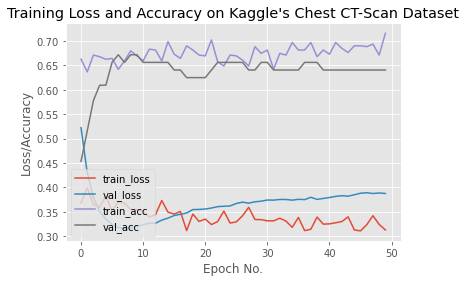

In [61]:
#Adadelta optimizer
from keras.optimizers import Adadelta
opt=Adadelta(learning_rate=init_lr, rho=0.95, epsilon=1e-07, name="Adadelta")
mymodel.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
M_adadelta=mymodel.fit_generator(
  trainGen,
  steps_per_epoch=lenTrain//batch_size,
  validation_data=valGen,
  validation_steps=lenVal//batch_size,
  epochs=epochs)
print("Evaluating the model with Adadelta optimizer.....\n")
print('------------------------------------------------------------------')
testGen.reset()
pred_indices=mymodel.predict_generator(testGen,steps=(lenTest//batch_size)+1)
pred_indices=np.argmax(pred_indices,axis=1)
print(classification_report(testGen.classes, pred_indices, target_names=testGen.class_indices.keys()))
print('------------------------------------------------------------------')
cm=confusion_matrix(testGen.classes,pred_indices)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
specificity=cm[1,1]/(cm[1,0]+cm[1,1])
sensitivity=cm[0,0]/(cm[0,0]+cm[0,1])
print(f"Classification matrix: \n{cm}")
print(f'\nAccuracy: {round(accuracy,4)}')
print(f'Specificity: {round(specificity,4)}')
print(f'Sensitivity: {round(sensitivity,4)}')
performance.append(["Adadelta",round(accuracy,4)])
print('------------------------------------------------------------------')
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), M_adadelta.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), M_adadelta.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), M_adadelta.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), M_adadelta.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Kaggle's Chest CT-Scan Dataset")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('accuracy_vs_error-using_adadelta-plot.png')
print('------------------------------------------------------------------')

Epoch 1/50
19/19 [==============================] - 29s 2s/step - loss: 0.2905 - accuracy: 0.7367 - val_loss: 0.4708 - val_accuracy: 0.6562
Epoch 2/50
19/19 [==============================] - 26s 1s/step - loss: 0.2809 - accuracy: 0.7401 - val_loss: 0.4865 - val_accuracy: 0.6562
Epoch 3/50
19/19 [==============================] - 29s 2s/step - loss: 0.2424 - accuracy: 0.7694 - val_loss: 0.9501 - val_accuracy: 0.5156
Epoch 4/50
19/19 [==============================] - 30s 2s/step - loss: 0.2452 - accuracy: 0.7986 - val_loss: 0.8435 - val_accuracy: 0.5625
Epoch 5/50
19/19 [==============================] - 27s 1s/step - loss: 0.2395 - accuracy: 0.7814 - val_loss: 0.9956 - val_accuracy: 0.5312
Epoch 6/50
19/19 [==============================] - 32s 2s/step - loss: 0.2404 - accuracy: 0.7969 - val_loss: 0.9656 - val_accuracy: 0.5469
Epoch 7/50
19/19 [==============================] - 30s 2s/step - loss: 0.2516 - accuracy: 0.7676 - val_loss: 0.9668 - val_accuracy: 0.5469
Epoch 8/50
19/19 [==

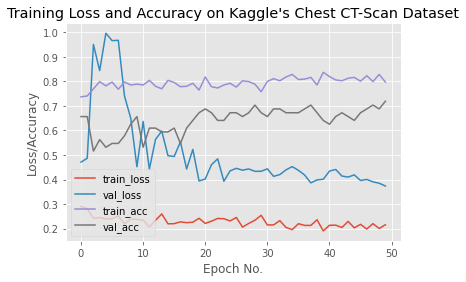

In [62]:
#Adamax optimizer
from keras.optimizers import Adamax
opt=Adamax(learning_rate=init_lr, epsilon=1e-07, name="Adamax")
mymodel.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
M_adamax=mymodel.fit_generator(
  trainGen,
  steps_per_epoch=lenTrain//batch_size,
  validation_data=valGen,
  validation_steps=lenVal//batch_size,
  epochs=epochs)
print("Evaluating the model with Adamax optimizer.....\n")
print('------------------------------------------------------------------')
testGen.reset()
pred_indices=mymodel.predict_generator(testGen,steps=(lenTest//batch_size)+1)
pred_indices=np.argmax(pred_indices,axis=1)
print(classification_report(testGen.classes, pred_indices, target_names=testGen.class_indices.keys()))
print('------------------------------------------------------------------')
cm=confusion_matrix(testGen.classes,pred_indices)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
specificity=cm[1,1]/(cm[1,0]+cm[1,1])
sensitivity=cm[0,0]/(cm[0,0]+cm[0,1])
print(f"Classification matrix: \n{cm}")
print(f'\nAccuracy: {round(accuracy,4)}')
print(f'Specificity: {round(specificity,4)}')
print(f'Sensitivity: {round(sensitivity,4)}')
performance.append(["Adamax",round(accuracy,4)])
print('------------------------------------------------------------------')
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), M_adamax.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), M_adamax.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), M_adamax.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), M_adamax.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Kaggle's Chest CT-Scan Dataset")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('accuracy_vs_error-using_adamax-plot.png')
print('------------------------------------------------------------------')

Epoch 1/50
19/19 [==============================] - 33s 2s/step - loss: 0.2366 - accuracy: 0.7831 - val_loss: 0.4542 - val_accuracy: 0.6562
Epoch 2/50
19/19 [==============================] - 30s 2s/step - loss: 0.2630 - accuracy: 0.7556 - val_loss: 0.5705 - val_accuracy: 0.6250
Epoch 3/50
19/19 [==============================] - 29s 2s/step - loss: 0.2301 - accuracy: 0.7866 - val_loss: 0.4366 - val_accuracy: 0.7031
Epoch 4/50
19/19 [==============================] - 28s 1s/step - loss: 0.2757 - accuracy: 0.7608 - val_loss: 0.5765 - val_accuracy: 0.5625
Epoch 5/50
19/19 [==============================] - 31s 2s/step - loss: 0.2729 - accuracy: 0.7418 - val_loss: 1.2029 - val_accuracy: 0.4375
Epoch 6/50
19/19 [==============================] - 28s 1s/step - loss: 0.2815 - accuracy: 0.7367 - val_loss: 2.7829 - val_accuracy: 0.2969
Epoch 7/50
19/19 [==============================] - 31s 2s/step - loss: 0.2866 - accuracy: 0.7281 - val_loss: 2.2535 - val_accuracy: 0.3750
Epoch 8/50
19/19 [==

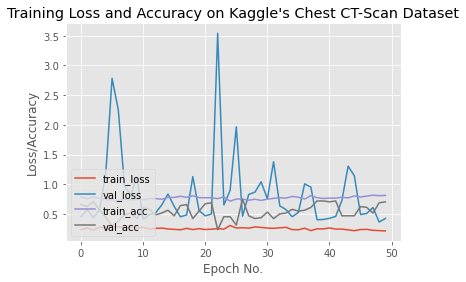

In [63]:
#Nadam optimizer
#Adadelta optimizer
from keras.optimizers import Nadam
opt=Nadam(learning_rate=init_lr,epsilon=1e-07, name="Nadam")
mymodel.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
M_nadam=mymodel.fit_generator(
  trainGen,
  steps_per_epoch=lenTrain//batch_size,
  validation_data=valGen,
  validation_steps=lenVal//batch_size,
  epochs=epochs)
print("Evaluating the model with Nadam optimizer.....\n")
print('------------------------------------------------------------------')
testGen.reset()
pred_indices=mymodel.predict_generator(testGen,steps=(lenTest//batch_size)+1)
pred_indices=np.argmax(pred_indices,axis=1)
print(classification_report(testGen.classes, pred_indices, target_names=testGen.class_indices.keys()))
print('------------------------------------------------------------------')
cm=confusion_matrix(testGen.classes,pred_indices)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
specificity=cm[1,1]/(cm[1,0]+cm[1,1])
sensitivity=cm[0,0]/(cm[0,0]+cm[0,1])
print(f"Classification matrix: \n{cm}")
print(f'\nAccuracy: {round(accuracy,4)}')
print(f'Specificity: {round(specificity,4)}')
print(f'Sensitivity: {round(sensitivity,4)}')
performance.append(["Nadam",round(accuracy,4)])
print('------------------------------------------------------------------')
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), M_nadam.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), M_nadam.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), M_nadam.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), M_nadam.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Kaggle's Chest CT-Scan Dataset")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('accuracy_vs_error-using_nadam-plot.png')
print('------------------------------------------------------------------')

Epoch 1/50
19/19 [==============================] - 28s 1s/step - loss: 0.5620 - accuracy: 0.3184 - val_loss: 0.5619 - val_accuracy: 0.3594
Epoch 2/50
19/19 [==============================] - 29s 2s/step - loss: 0.5616 - accuracy: 0.3150 - val_loss: 0.5618 - val_accuracy: 0.3594
Epoch 3/50
19/19 [==============================] - 29s 2s/step - loss: 0.5610 - accuracy: 0.3253 - val_loss: 0.5618 - val_accuracy: 0.3594
Epoch 4/50
19/19 [==============================] - 29s 2s/step - loss: 0.5607 - accuracy: 0.3167 - val_loss: 0.5618 - val_accuracy: 0.3594
Epoch 5/50
19/19 [==============================] - 28s 1s/step - loss: 0.5604 - accuracy: 0.3201 - val_loss: 0.5617 - val_accuracy: 0.3594
Epoch 6/50
19/19 [==============================] - 26s 1s/step - loss: 0.5603 - accuracy: 0.3133 - val_loss: 0.5616 - val_accuracy: 0.3594
Epoch 7/50
19/19 [==============================] - 28s 1s/step - loss: 0.5599 - accuracy: 0.3201 - val_loss: 0.5616 - val_accuracy: 0.3594
Epoch 8/50
19/19 [==

C:\Users\Ashika\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

         adenocarcinoma       0.38      1.00      0.55       120
   large.cell.carcinoma       0.00      0.00      0.00        51
            normal_xray       0.00      0.00      0.00        54
squamous.cell.carcinoma       0.00      0.00      0.00        90

               accuracy                           0.38       315
              macro avg       0.10      0.25      0.14       315
           weighted avg       0.15      0.38      0.21       315

------------------------------------------------------------------
Classification matrix: 
[[120   0   0   0]
 [ 51   0   0   0]
 [ 54   0   0   0]
 [ 90   0   0   0]]

Accuracy: 0.381
Specificity: 0.0
Sensitivity: 1.0
------------------------------------------------------------------
------------------------------------------------------------------


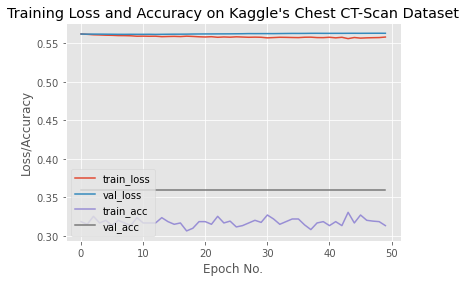

In [96]:
#FTRL optimizer
from keras.optimizers import Ftrl
opt=Ftrl(learning_rate=init_lr, name="Ftrl",)
mymodel.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
M_ftrl=mymodel.fit_generator(
  trainGen,
  steps_per_epoch=lenTrain//batch_size,
  validation_data=valGen,
  validation_steps=lenVal//batch_size,
  epochs=epochs)
print("Evaluating the model with Ftrl optimizer.....\n")
print('------------------------------------------------------------------')
testGen.reset()
pred_indices=mymodel.predict_generator(testGen,steps=(lenTest//batch_size)+1)
pred_indices=np.argmax(pred_indices,axis=1)
print(classification_report(testGen.classes, pred_indices, target_names=testGen.class_indices.keys()))
print('------------------------------------------------------------------')
cm=confusion_matrix(testGen.classes,pred_indices)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
specificity=cm[1,1]/(cm[1,0]+cm[1,1])
sensitivity=cm[0,0]/(cm[0,0]+cm[0,1])
print(f"Classification matrix: \n{cm}")
print(f'\nAccuracy: {round(accuracy,4)}')
print(f'Specificity: {round(specificity,4)}')
print(f'Sensitivity: {round(sensitivity,4)}')
performance.append(["Ftrl",round(accuracy,4)])
print('------------------------------------------------------------------')
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), M_ftrl.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), M_ftrl.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), M_ftrl.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), M_ftrl.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Kaggle's Chest CT-Scan Dataset")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('accuracy_vs_error-using_ftrl-plot.png')
print('------------------------------------------------------------------')

In [97]:
print(performance)

[['Adagrad', 0.2286], ['Adam', 0.0095], ['SGD', 0.219], ['RMSProp', 0.0095], ['Adadelta', 0.2], ['Adamax', 0.1905], ['Nadam', 0.2254], ['Ftrl', 0.381]]


In [98]:
from pandas import DataFrame
df = DataFrame(performance, columns=['Optimizer','Accuracy'])
print(df)

  Optimizer  Accuracy
0   Adagrad    0.2286
1      Adam    0.0095
2       SGD    0.2190
3   RMSProp    0.0095
4  Adadelta    0.2000
5    Adamax    0.1905
6     Nadam    0.2254
7      Ftrl    0.3810


In [103]:
x = 0
y = 1
for k in performance:
    if k[1]>x:
        x = k[1]
        opt_max = k[0]
    if k[1]<y:
        y = k[1]
        opt_min = k[0]

In [104]:
print(f"Max-->{opt_max},{x}\nMin-->{opt_min},{y}")

Max-->Ftrl,0.381
Min-->Adam,0.0095


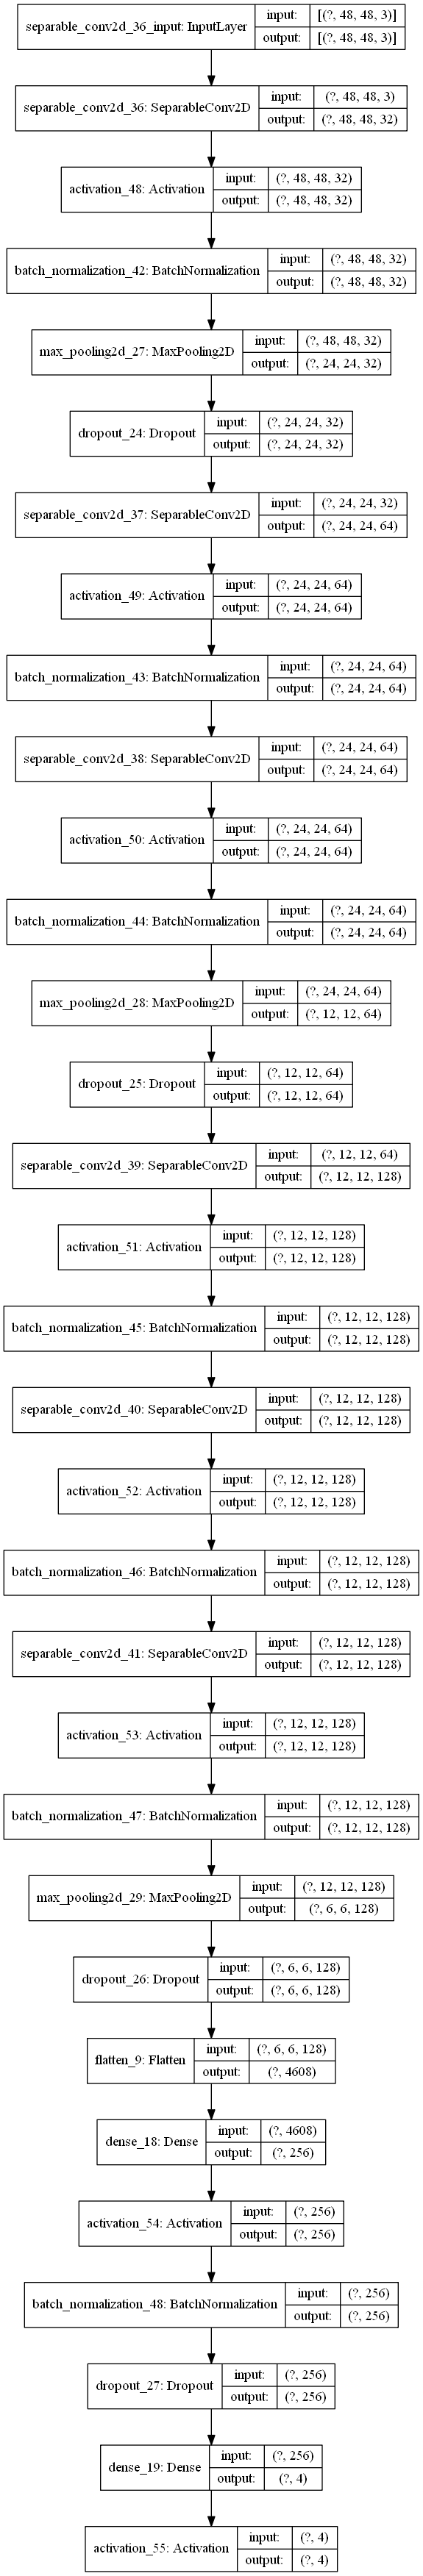

In [101]:
tf.keras.utils.plot_model(mymodel,'mymodel.png',show_layer_names=True,show_shapes=True)

## - Now we'll implement a model with the best performing optimizer

Epoch 1/5
19/19 [==============================] - 32s 2s/step - loss: 0.5620 - accuracy: 0.2874 - val_loss: 0.5625 - val_accuracy: 0.3594
Epoch 2/5
19/19 [==============================] - 30s 2s/step - loss: 0.5616 - accuracy: 0.3167 - val_loss: 0.5625 - val_accuracy: 0.3594
Epoch 3/5
19/19 [==============================] - 31s 2s/step - loss: 0.5612 - accuracy: 0.3253 - val_loss: 0.5623 - val_accuracy: 0.3594
Epoch 4/5
19/19 [==============================] - 28s 1s/step - loss: 0.5608 - accuracy: 0.3167 - val_loss: 0.5621 - val_accuracy: 0.3594
Epoch 5/5
19/19 [==============================] - 30s 2s/step - loss: 0.5605 - accuracy: 0.3236 - val_loss: 0.5620 - val_accuracy: 0.3594
Evaluating the model.....

------------------------------------------------------------------


C:\Users\Ashika\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

         adenocarcinoma       0.38      1.00      0.55       120
   large.cell.carcinoma       0.00      0.00      0.00        51
            normal_xray       0.00      0.00      0.00        54
squamous.cell.carcinoma       0.00      0.00      0.00        90

               accuracy                           0.38       315
              macro avg       0.10      0.25      0.14       315
           weighted avg       0.15      0.38      0.21       315

------------------------------------------------------------------
Classification matrix: 
[[120   0   0   0]
 [ 51   0   0   0]
 [ 54   0   0   0]
 [ 90   0   0   0]]
------------------------------------------------------------------
------------------------------------------------------------------


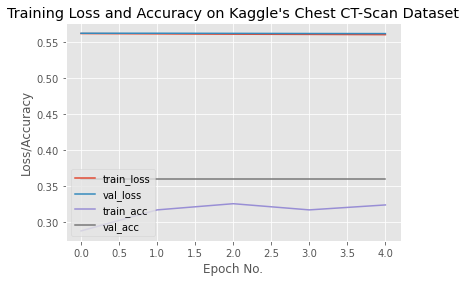

In [126]:
epochs=5
opt=Ftrl(learning_rate=init_lr,name="FTRL")
mymodel.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
M=mymodel.fit_generator(
  trainGen,
  steps_per_epoch=lenTrain//batch_size,
  validation_data=valGen,
  validation_steps=lenVal//batch_size,
  epochs=epochs)
print("Evaluating the model.....\n")
print('------------------------------------------------------------------')
testGen.reset()
pred_indices=mymodel.predict_generator(testGen,steps=(lenTest//batch_size)+1)
pred_indices=np.argmax(pred_indices,axis=1)
print(classification_report(testGen.classes, pred_indices, target_names=testGen.class_indices.keys()))
print('------------------------------------------------------------------')
cm=confusion_matrix(testGen.classes,pred_indices)
print(f"Classification matrix: \n{cm}")
print('------------------------------------------------------------------')
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), M.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), M.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), M.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), M.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Kaggle's Chest CT-Scan Dataset")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('final accuracy_vs_error plot.png')
print('------------------------------------------------------------------')